Python実践データ分析100本ノック（秀和システム）の勉強記録を載せています。<br>
問題の解説、コードを載せています。参考になれば幸いです。<br>
わからない点等ございましたらコメントお願いします。¶

# 第10章 アンケート分析を行うための自然言語処理10本ノック

自然言語処理（Natural Language Processing、NLP）を行う。<br>不動産業者の方が行ったまちづくりに関するアンケートを分析する。

* ## データ一覧

| No. | ファイル名 | 概要 | 
| :-- | :-- | :-- |
| 1 | survey.csv | アンケート結果 |

## ノック91 : データを読み込んで把握しよう

In [1]:
import pandas as pd

survey = pd.read_csv('../input/100knock-nlp/survey.csv')
print('アンケートの件数 : ' + str(len(survey)))
survey.head()

アンケートの件数 : 86


,datetime,comment,satisfaction
0,2019/3/11,駅前に若者が集まっている(AA駅),1
1,2019/2/25,スポーツできる場所があるのが良い,5
2,2019/2/18,子育て支援が嬉しい,5
3,2019/4/9,保育園に入れる（待機児童なし）,4
4,2019/1/6,駅前商店街が寂しい,2


In [2]:
# 欠損値の確認
survey.isna().sum()

datetime        0
comment         2
satisfaction    0
dtype: int64

二個だけコメント欄が空白のものがあるみたい<br>→今回は件数が全体（86件）に対して少ないので無視してみる

In [3]:
# コメントがない行を削除
survey = survey.dropna()
survey.isna().sum()

datetime        0
comment         0
satisfaction    0
dtype: int64

## ノック92 : 不要な文字を除外する

In [4]:
# 練習も兼ねて「AA」と言う文字列を消してみる
survey['comment'] = survey['comment'].str.replace('AA', '')
survey.head()

,datetime,comment,satisfaction
0,2019/3/11,駅前に若者が集まっている(駅),1
1,2019/2/25,スポーツできる場所があるのが良い,5
2,2019/2/18,子育て支援が嬉しい,5
3,2019/4/9,保育園に入れる（待機児童なし）,4
4,2019/1/6,駅前商店街が寂しい,2


次は正規表現を使ってかっことかっこの中身を削除してみる。<br>[Pythonで優しくしっかり学ぶ正規表現](https://qiita.com/simonritchie/items/43b3dfd9419f442d48ad)が非常に参考になった。（ありがとうございます...）<br>replaceコマンドに特化した形だと、[pandas.DataFrame, Seriesの要素の値を置換するreplace](https://note.nkmk.me/python-pandas-replace/#_6)もかなり良かった。例が豊富でわかりやすい。

In [5]:
# かぎかっこと、かぎかっこの中身のコメントを取り除く

# regex=Trueとすることでreplaceメソッドで正規表現を使用することができる
survey['comment'] = survey['comment'].str.replace('\(.+?\)', '', regex=True) # 半角かっこ
survey['comment'] = survey['comment'].str.replace('\（.+?\）', '' , regex=True) # 全角かっこ
survey.head()

,datetime,comment,satisfaction
0,2019/3/11,駅前に若者が集まっている,1
1,2019/2/25,スポーツできる場所があるのが良い,5
2,2019/2/18,子育て支援が嬉しい,5
3,2019/4/9,保育園に入れる,4
4,2019/1/6,駅前商店街が寂しい,2


* ### コード中の正規表現について
\( \)　: 鉤括弧を文字として指定。通常正規表現では()はグループ化するときに使うので、文字として指定する場合にはバックスラッシュが必要。<br>
. : 任意の文字（一文字）<br>
\+ : 一つ前の文字に対して、一回以上の繰り返しがあるか
? : 直前のパターンの0から1回の繰り返し（つまり.+?で任意の文字列を指定できる）


## ノック93 : 文字数をカウントしてヒストグラムを表示する

In [6]:
survey['length'] = survey['comment'].str.len()
survey.head()

,datetime,comment,satisfaction,length
0,2019/3/11,駅前に若者が集まっている,1,12
1,2019/2/25,スポーツできる場所があるのが良い,5,16
2,2019/2/18,子育て支援が嬉しい,5,9
3,2019/4/9,保育園に入れる,4,7
4,2019/1/6,駅前商店街が寂しい,2,9


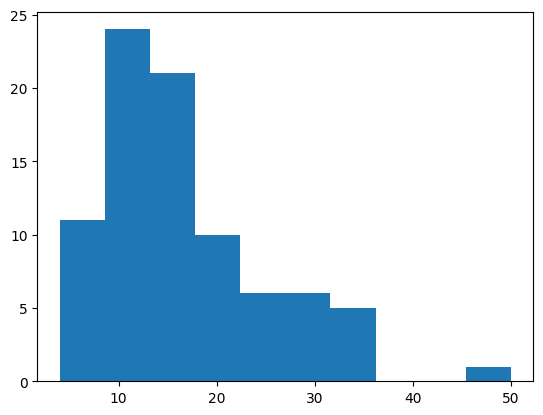

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(survey['length'])
plt.show()

大体10文字から20文字程度のコメントが多い。一言コメントが多いと考えられる。

# ノック94 : 形態素解析で文章を分割する

* ## 形態素解析とは

文章を単語に分割する技術のこと。ここでは、MeCabを用いて進めていく。<br>まずはサンプルとして「すもももももももものうち」を単語に分割してみる。（形態素解析のHello Worldにあたるらしい）

In [8]:
!pip install mecab-python3 unidic-lite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 32.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 14.3 MB/s eta 0:00:00
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658818 sha256=12ff7c1d9a29340ac9c78eb0b1920b048f8417555830c4e1a3e425c2a28bf7dd
  Stored in directory: /root/.cache/pip/wheels/89/e8/68/f9ac36b8cc6c8b3c96888cd57434abed96595d444f42243853
Successfully built unidic-lite


In [9]:
import MeCab

tagger = MeCab.Tagger() # 形態素解析器の初期化
text = 'すもももももももものうち'
words = tagger.parse(text) # 形態素解析を実施
words

'すもも\tスモモ\tスモモ\t李\t名詞-普通名詞-一般\t\t\t0\nも\tモ\tモ\tも\t助詞-係助詞\t\t\t\nもも\tモモ\tモモ\t桃\t名詞-普通名詞-一般\t\t\t0\nも\tモ\tモ\tも\t助詞-係助詞\t\t\t\nもも\tモモ\tモモ\t桃\t名詞-普通名詞-一般\t\t\t0\nの\tノ\tノ\tの\t助詞-格助詞\t\t\t\nうち\tウチ\tウチ\t内\t名詞-普通名詞-副詞可能\t\t\t0\nEOS\n'

単語や品詞などが表示されている。\nで一つの単語に分割していて、\t以降は品詞などの付属情報が含まれている。

In [10]:
# さっきの結果を「\n」で区切って配列に格納する
words = tagger.parse(text).splitlines()
words

['すもも\tスモモ\tスモモ\t李\t名詞-普通名詞-一般\t\t\t0',
 'も\tモ\tモ\tも\t助詞-係助詞\t\t\t',
 'もも\tモモ\tモモ\t桃\t名詞-普通名詞-一般\t\t\t0',
 'も\tモ\tモ\tも\t助詞-係助詞\t\t\t',
 'もも\tモモ\tモモ\t桃\t名詞-普通名詞-一般\t\t\t0',
 'の\tノ\tノ\tの\t助詞-格助詞\t\t\t',
 'うち\tウチ\tウチ\t内\t名詞-普通名詞-副詞可能\t\t\t0',
 'EOS']

「EOS」は文の終わりを表す特殊文字

In [11]:
words_arr = []
for i in words:
    if i == 'EOS' : continue # 特殊文字「EOS」はwords_arrに追加しない
    # 文字の部分だけ取り出す（配列の２番目以降には付属情報が入っている）
    word_tmp = i.split()[0] 
    words_arr.append(word_tmp)
words_arr

['すもも', 'も', 'もも', 'も', 'もも', 'の', 'うち']

## ノック95 : 形態素解析で文章から「動詞・名詞」を抽出する

In [12]:
text = 'すもももももももものうち'
words = tagger.parse(text).splitlines()
words_arr = []

parts = ['名詞', '動詞']
for i in words:
    if i == 'EOS' or i == '' : continue # EOSと空白は無視
    word_tmp = i.split()[0]
    # 品詞の情報は前から5番目（そのうち大分類は一番目）
    part = i.split()[4].split('-')[0]
    # 動詞と名詞以外の場合は追加しない
    if not (part in parts): continue 
    words_arr.append(word_tmp)

words_arr

['すもも', 'もも', 'もも', 'うち']

ここから先は名詞に絞ってsurveyデータを分析していく。

## ノック96 : 形態素解析で抽出した頻出する名詞を確認する

surveyデータのcomment列を単語に分割して、all_wordsリストに全て追加していく。そのあと足し上げる。

In [13]:
all_words = []
parts = ['名詞']
for n in range(len(survey)):
    # コメントを一行分抽出
    text = survey['comment'].iloc[n]
    words = tagger.parse(text).splitlines()
    words_arr = []
    for i in words:
        if i == 'EOS' or i == '' : continue
        word_tmp = i.split()[0]
        # list index out of range　対策
        if len(i.split()) >= 4:
            part = i.split()[4].split('-')[0]
            if not(part in parts) : continue
            words_arr.append(word_tmp)
    all_words.extend(words_arr)
print(all_words)

['駅前', '若者', 'スポーツ', '場所', '子育て', '支援', '保育', '駅前', '商店', '生活', '便利', '場所', '場所', '商業', '施設', '病院', '充実', 'サイクリング', 'コース', '祭り', '学校', '公園', '近く', '公園', 'スーパー', '子育て', 'デート', 'スポット', '商店', '夜道', 'ゴミ', '処理', '楽', '映画', '街路', '公園', '追加', '観光', 'スポット', '子育て', '道', '都内', 'アクセス', '家賃', 'BBB', '渋滞', '商店', '屋根', '雨', '商店', '喫茶', 'スポーツ', 'ジム', '利用', 'スポーツ', 'ジム', '利用', '料金', 'ママ', '支援', 'バス', '自転', 'ランニング', '運動', '場所', '企業', '駅前', '駐車', '変', 'おじ', '声', '事', '警察', '巡回', '強化', '消防', '安心', '災害', '時', '避難', '場所', '気', '最近', '川', '氾濫', '被害', '町', '氾濫', '防止', '説明', '信号', '交差', '点', 'ｘｘｘ', '事故', '信号', '商店', '活性', '活動', '行政', '後押し', '子ども', '安全', '場所', '駅前', '駐輪', '不便', '街路', '落ち葉', '掃除', '街路', '災害', '時', '備蓄', '状況', '歩道', '道', '安心', '地域', '自治', '体', '支援', '自治', '体', '活動', '安心', '観光', '地', '最近', '他県', 'ナンバー', '車', '防犯', '駐車', '数', '料金', '駅前', '公共', '駐車', '歩行', '信号', '老人', '子供', '事', '設定', '急行', '都内', 'バス', '路線', '春', '桜', '並木', '最高', '桜', '並木', '隣町', 'ごみ', '処理', '施設', '心配', '公害', '市長', '活気', 'アンケート', '

複数存在する単語があるので、データフレームに格納してから集計を行う。

In [14]:
# count列の中身はは一旦適当に埋めておく
all_words_df = pd.DataFrame({'words' : all_words, 'count' : len(all_words) * [1]})
all_words_df = all_words_df.groupby('words').sum()
all_words_df.sort_values('count', ascending=False).head(20)

,count
words,
駅前,7
場所,6
商店,5
公園,5
役所,5
対応,4
駐車,4
信号,3
道,3


名詞だけを取得してもノイズのような単語が含まれてしまうことが多い。

## ノック97 : 関係のなさそうな単語の除去

「形態素解析をする際に数えない」ことが有効。

In [15]:
stop_words = ['時'] # 「時」という単語を含まないようにする
all_words = []
parts = ['名詞']
for n in range(len(survey)):
    text = survey['comment'].iloc[n]
    words = tagger.parse(text).splitlines()
    words_arr = []
    for i in words:
        if i == 'EOS' or i == '' : continue
        word_tmp = i.split()[0]
        # list index out of range　対策
        if len(i.split()) >= 4:
            part = i.split()[4].split('-')[0]
            if not(part in parts) : continue
            if word_tmp in stop_words : continue
            words_arr.append(word_tmp)
    all_words.extend(words_arr)
print(all_words)

['駅前', '若者', 'スポーツ', '場所', '子育て', '支援', '保育', '駅前', '商店', '生活', '便利', '場所', '場所', '商業', '施設', '病院', '充実', 'サイクリング', 'コース', '祭り', '学校', '公園', '近く', '公園', 'スーパー', '子育て', 'デート', 'スポット', '商店', '夜道', 'ゴミ', '処理', '楽', '映画', '街路', '公園', '追加', '観光', 'スポット', '子育て', '道', '都内', 'アクセス', '家賃', 'BBB', '渋滞', '商店', '屋根', '雨', '商店', '喫茶', 'スポーツ', 'ジム', '利用', 'スポーツ', 'ジム', '利用', '料金', 'ママ', '支援', 'バス', '自転', 'ランニング', '運動', '場所', '企業', '駅前', '駐車', '変', 'おじ', '声', '事', '警察', '巡回', '強化', '消防', '安心', '災害', '避難', '場所', '気', '最近', '川', '氾濫', '被害', '町', '氾濫', '防止', '説明', '信号', '交差', '点', 'ｘｘｘ', '事故', '信号', '商店', '活性', '活動', '行政', '後押し', '子ども', '安全', '場所', '駅前', '駐輪', '不便', '街路', '落ち葉', '掃除', '街路', '災害', '備蓄', '状況', '歩道', '道', '安心', '地域', '自治', '体', '支援', '自治', '体', '活動', '安心', '観光', '地', '最近', '他県', 'ナンバー', '車', '防犯', '駐車', '数', '料金', '駅前', '公共', '駐車', '歩行', '信号', '老人', '子供', '事', '設定', '急行', '都内', 'バス', '路線', '春', '桜', '並木', '最高', '桜', '並木', '隣町', 'ごみ', '処理', '施設', '心配', '公害', '市長', '活気', 'アンケート', '確認', '街づくり

In [16]:
# count列の中身はは一旦適当に埋めておく
all_words_df = pd.DataFrame({'words' : all_words, 'count' : len(all_words) * [1]})
all_words_df = all_words_df.groupby('words').sum()
all_words_df.sort_values('count', ascending=False).head(20)

,count
words,
駅前,7
場所,6
役所,5
商店,5
公園,5
対応,4
駐車,4
子育て,3
道,3


「時」がランキングから消えているのがわかる！

## ノック98 : 顧客満足度と頻出単語の関係を見てみよう

In [17]:
stop_words = ['時']
parts = ['名詞']
all_words = []
satisfaction = []
for n in range(len(survey)):
    text = survey['comment'].iloc[n]
    words = tagger.parse(text).splitlines()
    words_arr = []
    for i in words:
        if i == 'EOS' or i == '' : continue
        word_tmp = i.split()[0]
        # list index out of range　対策
        if len(i.split()) >= 4:
            part = i.split()[4].split('-')[0]
            if not(part in parts) : continue
            if word_tmp in stop_words : continue
            words_arr.append(word_tmp)
            satisfaction.append(survey['satisfaction'].iloc[n])
    all_words.extend(words_arr)

# count列は適当に埋めていることに注意
all_words_df = pd.DataFrame({'words' : all_words, 'satisfaction' : satisfaction, 
                             'count' : len(all_words) * [1]})
all_words_df.head()


,words,satisfaction,count
0,駅前,1,1
1,若者,1,1
2,スポーツ,5,1
3,場所,5,1
4,子育て,5,1


In [18]:
# wordsごとに集計
words_satisfaction = all_words_df.groupby('words').mean()['satisfaction']
words_satisfaction.head()

words
BBB    2.0
おじ     1.0
ごみ     2.0
とき     5.0
まち     2.0
Name: satisfaction, dtype: float64

In [19]:
words_count = all_words_df.groupby('words').sum()['count']
words_df = pd.concat([words_satisfaction, words_count], axis=1)
words_df.head()

,satisfaction,count
words,,
BBB,2.0,1
おじ,1.0,1
ごみ,2.0,1
とき,5.0,1
まち,2.0,1


3回以上出現しているデータに絞ってみる

In [20]:
words_df = words_df.loc[words_df['count'] >= 3]
# ascending=Falseで降順にできる
words_df.sort_values('satisfaction', ascending=False).head()

,satisfaction,count
words,,
子育て,4.333333,3
安心,4.333333,3
スポーツ,3.666667,3
場所,3.000000,6
役所,3.000000,5


In [21]:
words_df.sort_values('satisfaction').head()

,satisfaction,count
words,,
駐車,1.000000,4
信号,1.333333,3
駅前,1.428571,7
街路,1.666667,3
対応,2.000000,4


## ノック99 : アンケートごとの特徴を表現してみよう

カウントベースの手法の一つとして、「どの単語が含まれているか」ということのみを特徴にしていく。

In [22]:
parts = ['名詞']
all_words_df = pd.DataFrame()
satisfaction = []
for n in range(len(survey)):
    text = survey['comment'].iloc[n]
    words = tagger.parse(text).splitlines()
    words_df = pd.DataFrame()
    for i in words:
        if i == 'EOS' or i == '' : continue
        word_tmp = i.split()[0]
        if (len(i.split()) >= 4):
            part = i.split()[4].split('-')[0]
            if not (part in parts) :continue
            words_df[word_tmp] = [1]
    all_words_df = pd.concat([all_words_df, words_df], ignore_index=True)
all_words_df.head()

,駅前,若者,スポーツ,場所,子育て,支援,保育,商店,生活,便利,...,まち,マスコット,夜間,不安,高齢,サポート,校庭,芝生,投稿,道具
0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* #### 出てきた全ての単語に対して、One-Hotラベル変換しているようなイメージ

In [23]:
# 欠損値を0に変更
all_words_df = all_words_df.fillna(0)
all_words_df.head()

,駅前,若者,スポーツ,場所,子育て,支援,保育,商店,生活,便利,...,まち,マスコット,夜間,不安,高齢,サポート,校庭,芝生,投稿,道具
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# ノック100 : 類似アンケートを探してみよう

In [24]:
# 調査データ３番目のコメントと類似しているアンケートを抽出してみる
print(survey['comment'].iloc[2])
target_text = all_words_df.iloc[2]
print(target_text)

子育て支援が嬉しい
駅前      0.0
若者      0.0
スポーツ    0.0
場所      0.0
子育て     1.0
       ... 
サポート    0.0
校庭      0.0
芝生      0.0
投稿      0.0
道具      0.0
Name: 2, Length: 161, dtype: float64


文章の類似度の指標として、「コサイン類似度」を使用する。定義は、比べる配列をそれぞれ$x$、$y$として以下の通り。
### $$ \cos(x, y) = \frac{\langle x, y \rangle}{|x| |y|}$$
値は当然-1から1の範囲で、1に近いとよく似ている、0に近いと全く似ていない、-1だと逆の意味を持っているといった具合に類似度を測ることができる。

In [25]:
import numpy as np
cos_sim = []
for i in range(len(all_words_df)):
    cos_text = all_words_df.iloc[i]
    cos = np.dot(target_text, cos_text) / (np.linalg.norm(target_text) * np.linalg.norm(cos_text))
    cos_sim.append(cos)

# dfに変換してconcatで結合する方が処理が早いらしい
cos_sim_df = pd.DataFrame({'cos_sim' : cos_sim})
join_all_words = pd.concat([all_words_df, cos_sim_df], axis=1)
join_all_words.sort_values('cos_sim', ascending=False).head()

# 書籍コードだと結合速度が遅いらしくて怒られる
#all_words_df['cos_sim'] = cos_sim
#all_words_df.sort_values('cos_sim', ascending=False).head()

,駅前,若者,スポーツ,場所,子育て,支援,保育,商店,生活,便利,...,マスコット,夜間,不安,高齢,サポート,校庭,芝生,投稿,道具,cos_sim
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
24,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707107
15,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707107
33,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000
50,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.353553


上位5個のコメントを見てみる（インデックス番号で指定）

In [26]:
print(survey['comment'].iloc[2])
print(survey['comment'].iloc[24])
print(survey['comment'].iloc[15])
print(survey['comment'].iloc[33])
print(survey['comment'].iloc[50])

子育て支援が嬉しい
子育てがしやすい
子育てしやすい
働くママの支援をもっと増やして欲しい
地域の自治体をもっと支援してほしい


「子育て支援が嬉しい」に対して類似した文章（子育て関連の文章）を取り出すことができている。<br>ゼロから作るDeepLearning 2により詳しい分析方法（word2vecなど）が載っているのでぜひ挑戦しよう。